<a href="https://colab.research.google.com/github/Abdoo50/Stock-Market-Analysis/blob/main/Stock_Market_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Analysis Using `LSTM`

For our exercise, we’ll be looking at technical analysis solely and focusing on the Simple MA and Exponential MA techniques to predict stock prices. Additionally, we’ll utilize LSTM (Long Short-Term Memory), a deep learning framework for time-series, to build a predictive model and compare its performance against our technical analysis.

As stated in the disclaimer, stock trading strategy is not in the scope of this article. I’ll be using trading/investment terms only to help you better understand the analysis, but this is not financial advice. We’ll be using terms like:

## Getting the Data
The first step is to get the data and load it to memory. We will get our stock data from the Yahoo Finance website. Yahoo Finance is a rich resource of financial market data and tools to find compelling investments. To get the data from Yahoo Finance, we will be using yfinance library which offers a threaded and Pythonic way to download market data from Yahoo. Check this article to learn more about yfinance: [Reliably download historical market data from with Python](https://aroussi.com/post/python-yahoo-finance)

In [1]:
# !pip install pandas_datareader

In [2]:
# !pip install yfinance

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)


company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2023-06-23,129.110001,130.839996,128.279999,129.330002,129.330002,71855200,AMAZON
2023-06-26,129.330002,131.490005,127.099998,127.330002,127.330002,59989300,AMAZON
2023-06-27,128.630005,130.089996,127.550003,129.179993,129.179993,46801000,AMAZON
2023-06-28,128.940002,131.479996,128.440002,129.039993,129.039993,52149500,AMAZON
2023-06-29,128.770004,129.259995,127.260002,127.900002,127.900002,40761000,AMAZON
2023-06-30,129.470001,131.250000,128.949997,130.360001,130.360001,54310500,AMAZON
2023-07-03,130.820007,131.850006,130.070007,130.220001,130.220001,28264800,AMAZON
2023-07-05,130.240005,131.399994,129.639999,130.380005,130.380005,35895400,AMAZON
2023-07-06,128.250000,128.729996,127.370003,128.360001,128.360001,40639900,AMAZON


In this notebook, we will discover and explore data from the stock market, particularly some technology stocks (Apple, Amazon, Google, and Microsoft). We will learn how to use yfinance to get stock information, and visualize different aspects of it using Seaborn and Matplotlib. we will look at a few ways of analyzing the risk of a stock, based on its previous performance history. We will also be predicting future stock prices through a Long Short Term Memory (LSTM) method!

We'll be answering the following questions along the way:

- What was the change in price of the stock over time?
- What was the daily return of the stock on average?
- What was the moving average of the various stocks?
- What was the correlation between different stocks'?
- How much value do we put at risk by investing in a particular stock?
- How can we attempt to predict future stock behavior? (Predicting the closing price stock price of APPLE inc using LSTM)


# 1. What was the change in price of the stock overtime?

In this section we'll go over how to handle requesting stock information with pandas, and how to analyze basic attributes of a stock.

## Data Preprocessing

### Descriptive Statistics about the Data
`.describe()` generates descriptive statistics. Descriptive statistics include those that summarize the central tendency, dispersion, and shape of a dataset’s distribution, excluding `NaN` values.

Analyzes both numeric and object series, as well as `DataFrame` column sets of mixed data types. The output will vary depending on what is provided. Refer to the notes below for more detail.

In [4]:
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,155.891674,157.746454,154.326853,156.161115,155.746230,7.175067e+07
std,15.189696,14.992960,15.527174,15.313488,15.429304,2.268667e+07
min,126.010002,127.769997,124.169998,125.019997,124.656975,3.145820e+07
25%,145.305000,147.229996,143.315002,145.480003,145.027657,5.533940e+07
50%,153.110001,155.039993,151.130005,153.339996,152.988388,6.840220e+07
75%,166.095001,167.839996,165.150002,166.320000,166.090271,8.161725e+07
max,193.779999,194.479996,191.759995,193.970001,193.970001,1.647624e+08


We have only 255 records in one year because weekends are not included in the data.

### Information About the Data
`.info()` method prints information about a DataFrame including the index `dtype` and columns, non-null values, and memory usage.

In [5]:
# General info
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-07-08 to 2023-07-07
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          251 non-null    float64
 1   High          251 non-null    float64
 2   Low           251 non-null    float64
 3   Close         251 non-null    float64
 4   Adj Close     251 non-null    float64
 5   Volume        251 non-null    int64  
 6   company_name  251 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.7+ KB


## Closing Price

The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

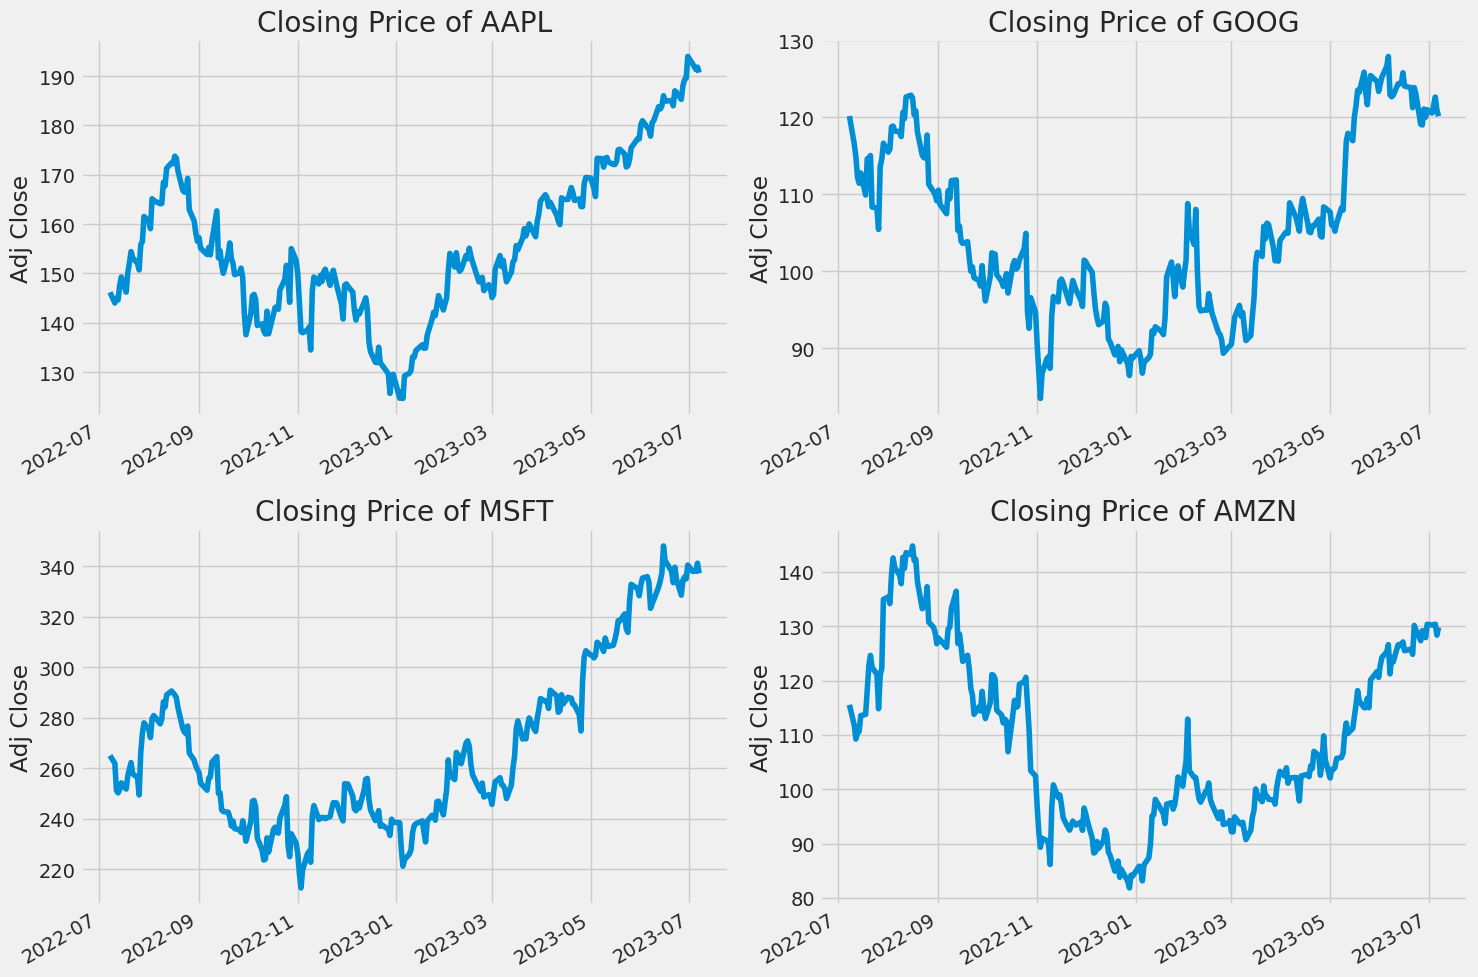

In [6]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")

plt.tight_layout()

## Volume of Sales
Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day. For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders.

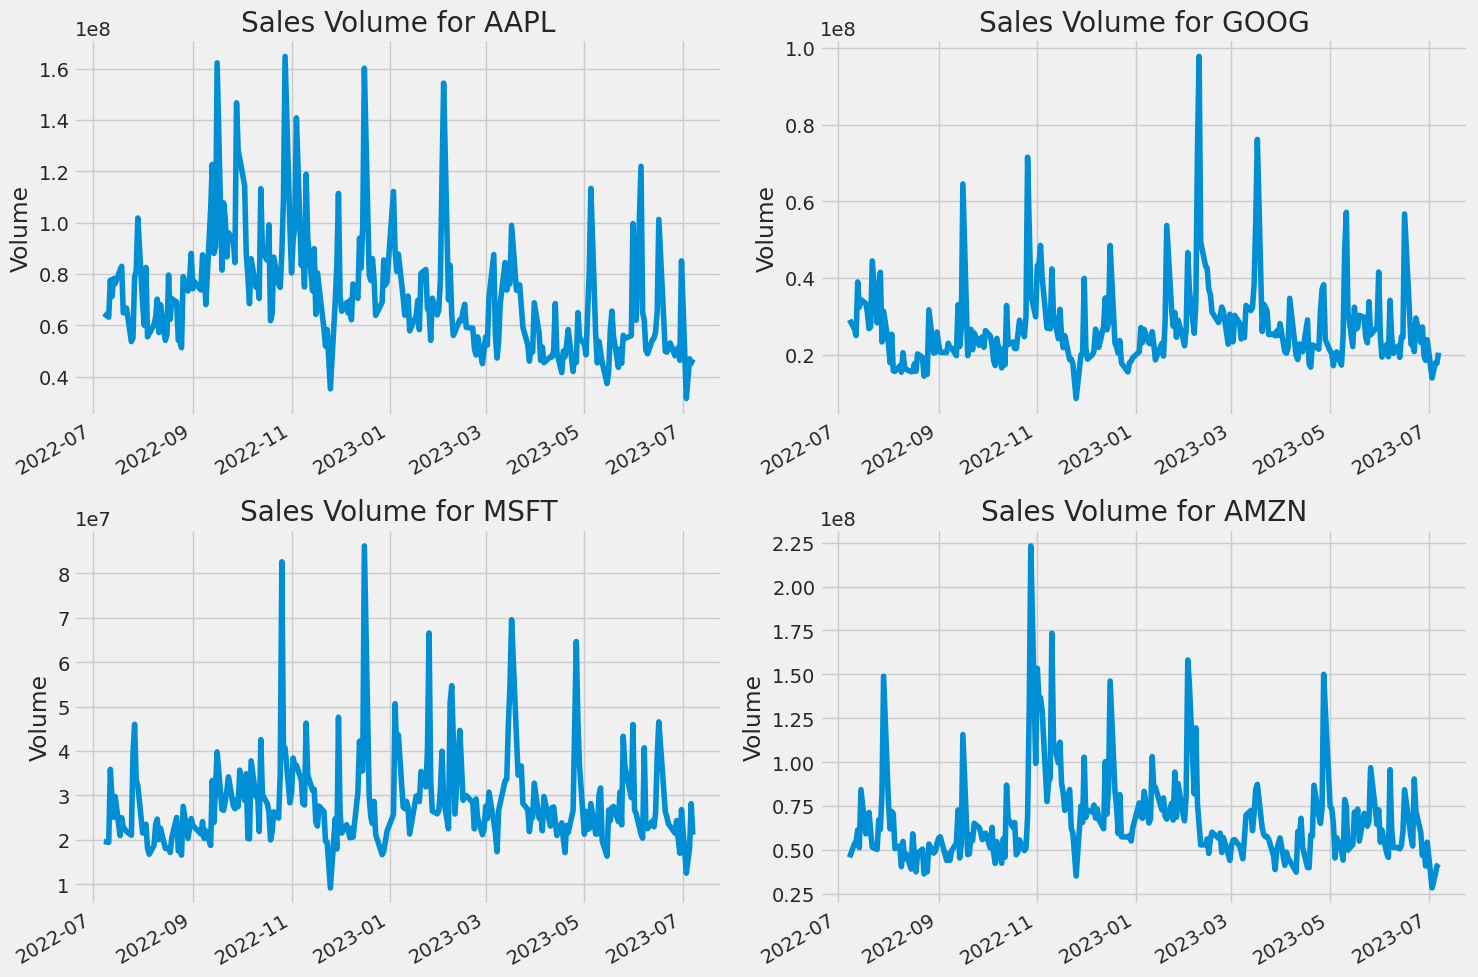

In [7]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")

plt.tight_layout()

Now that we've seen the visualizations for the closing price and the volume traded each day, let's go ahead and caculate the moving average for the stock.

# 2. What was the moving average of the various stocks?

The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

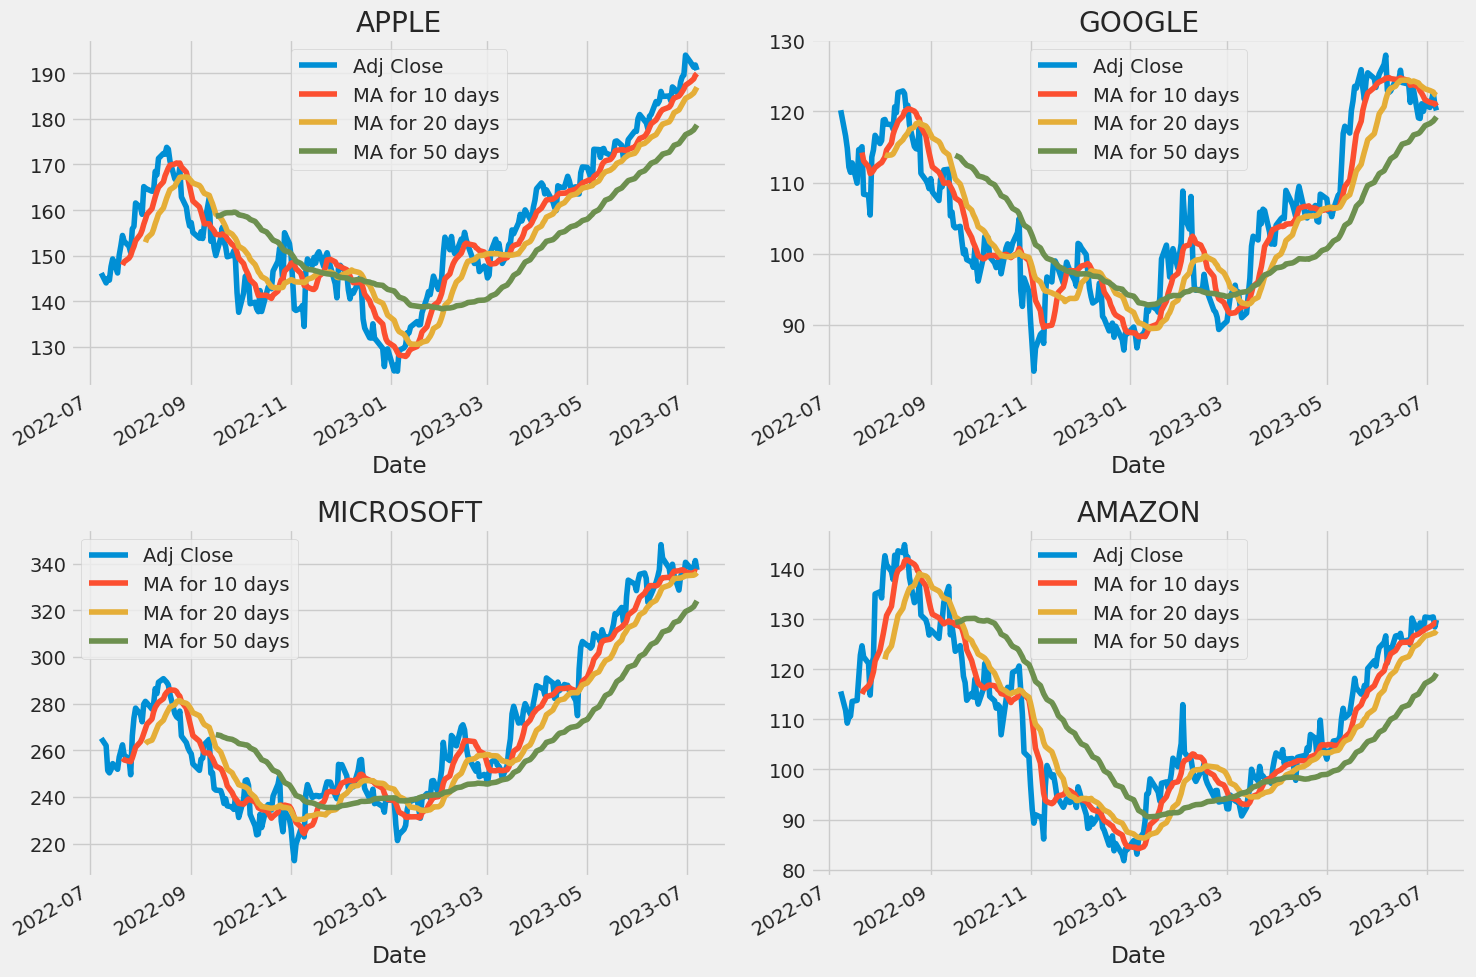

In [8]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()


fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

We see in the graph that the best values to measure the moving average are 10 and 20 days because we still capture trends in the data without noise.

# 3. What was the daily return of the stock on average?


Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve teh daily returns for the Apple stock.

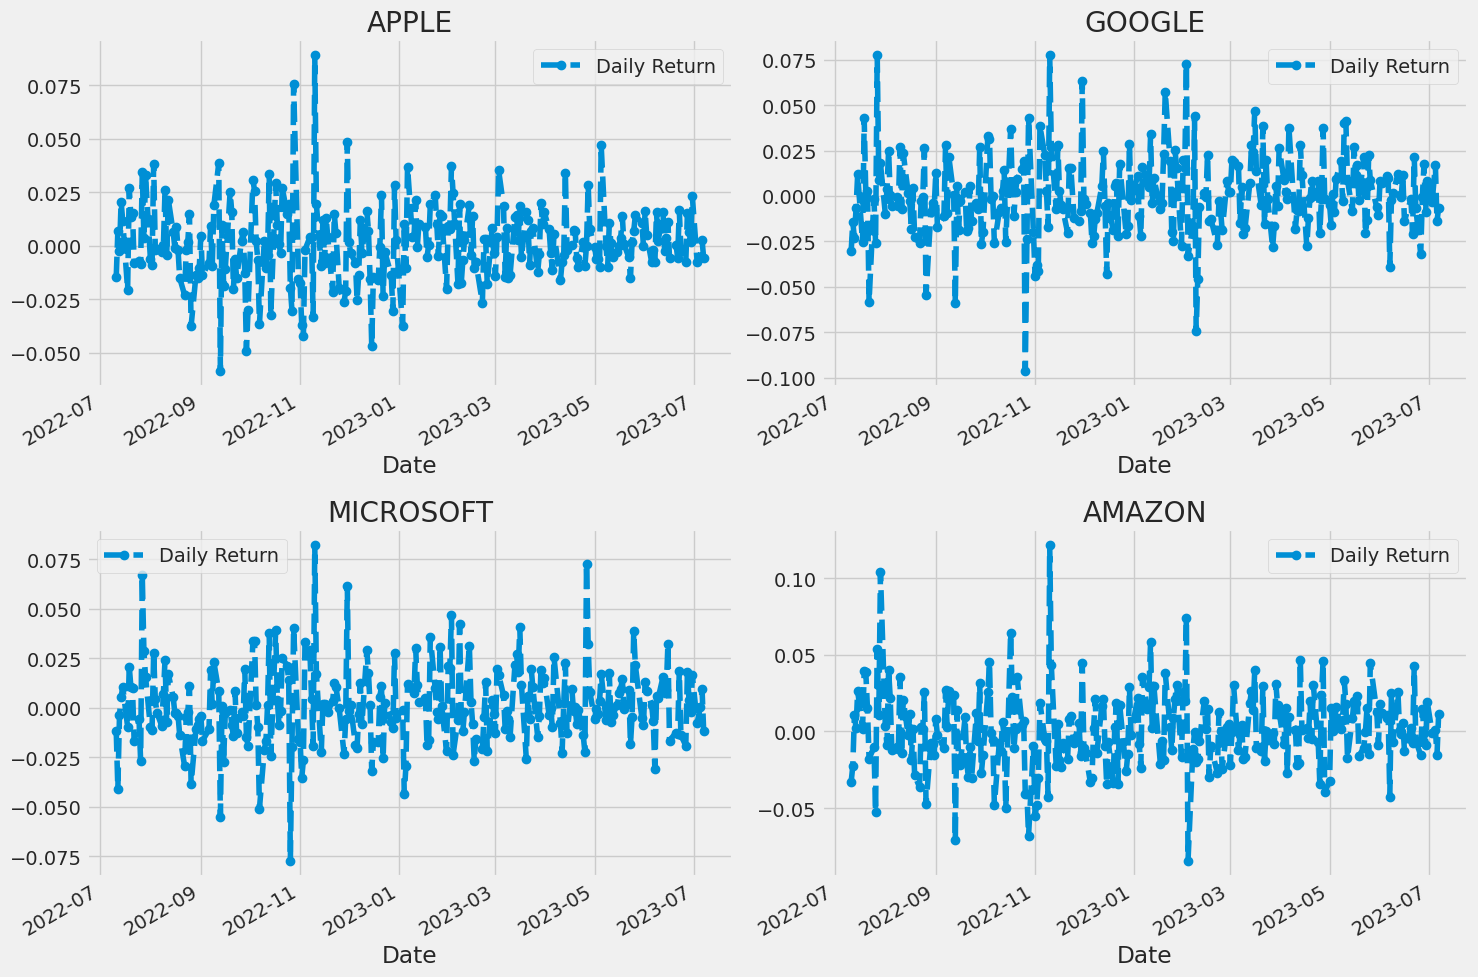

In [9]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

Great, now let's get an overall look at the average daily return using a histogram. We'll use seaborn to create both a histogram and kde plot on the same figure.

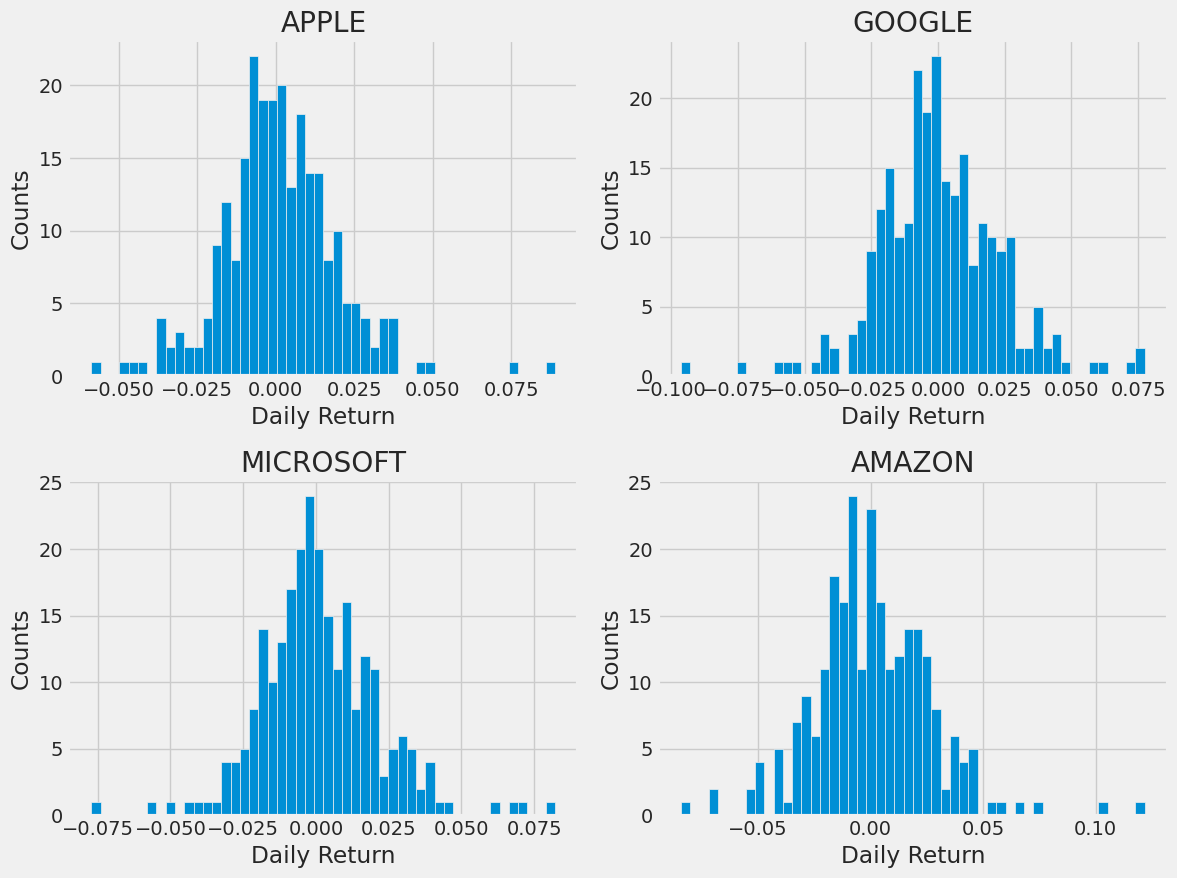

In [10]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')

plt.tight_layout()

# 4. What was the correlation between different stocks closing prices?

Correlation is a statistic that measures the degree to which two variables move in relation to each other which has a value that must fall between -1.0 and +1.0. Correlation measures association, but doesn’t show if x causes y or vice versa — or if the association is caused by a third factor[1].

Now what if we wanted to analyze the returns of all the stocks in our list? Let's go ahead and build a DataFrame with all the ['Close'] columns for each of the stocks dataframes.

In [11]:
# Grab all the closing prices for the tech stock list into one DataFrame

closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%***********************]  4 of 4 completed


,AAPL,AMZN,GOOG,MSFT
Date,,,,
2022-07-08,NaN,NaN,NaN,NaN
2022-07-11,-0.014758,-0.032803,-0.030341,-0.011769
2022-07-12,0.006834,-0.022640,-0.014358,-0.040981
2022-07-13,-0.002537,0.010804,-0.023183,-0.003745
2022-07-14,0.020483,0.002083,-0.006658,0.005381


we can compare the daily percentage return of two stocks to check how correlated. First let's see a sotck compared to itself.

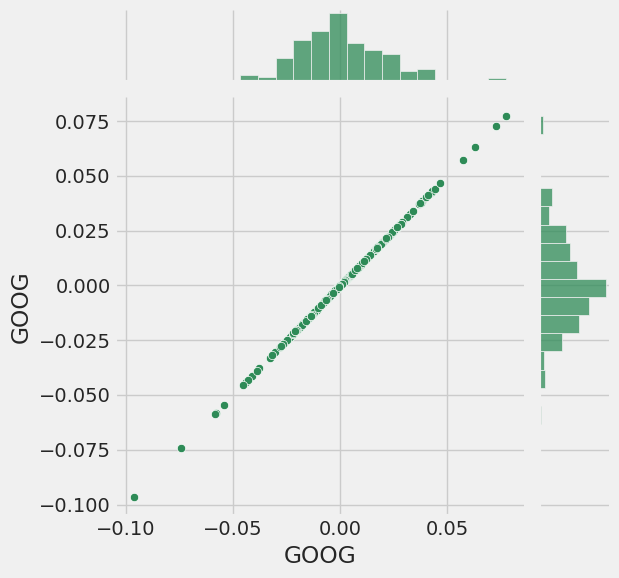

In [12]:
# Comparing Google to itself should show a perfectly linear relationship
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

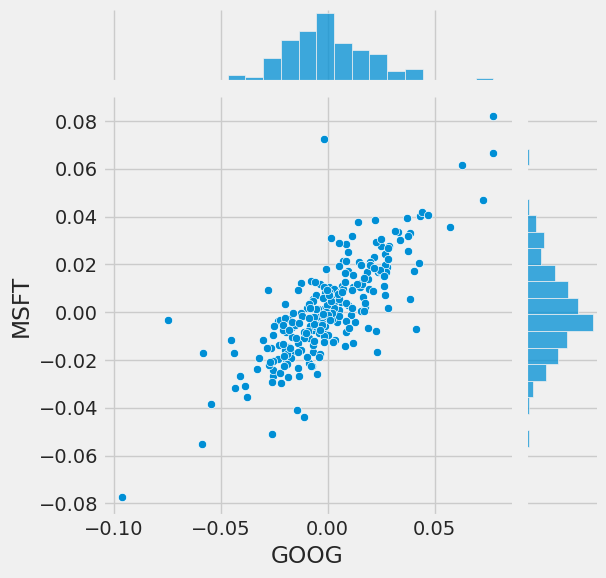

In [13]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

So now we can see that if two stocks are perfectly (and positivley) correlated with each other a linear relationship bewteen its daily return values should occur.

Seaborn and pandas make it very easy to repeat this comparison analysis for every possible combination of stocks in our technology stock ticker list. We can use sns.pairplot() to automatically create this plot

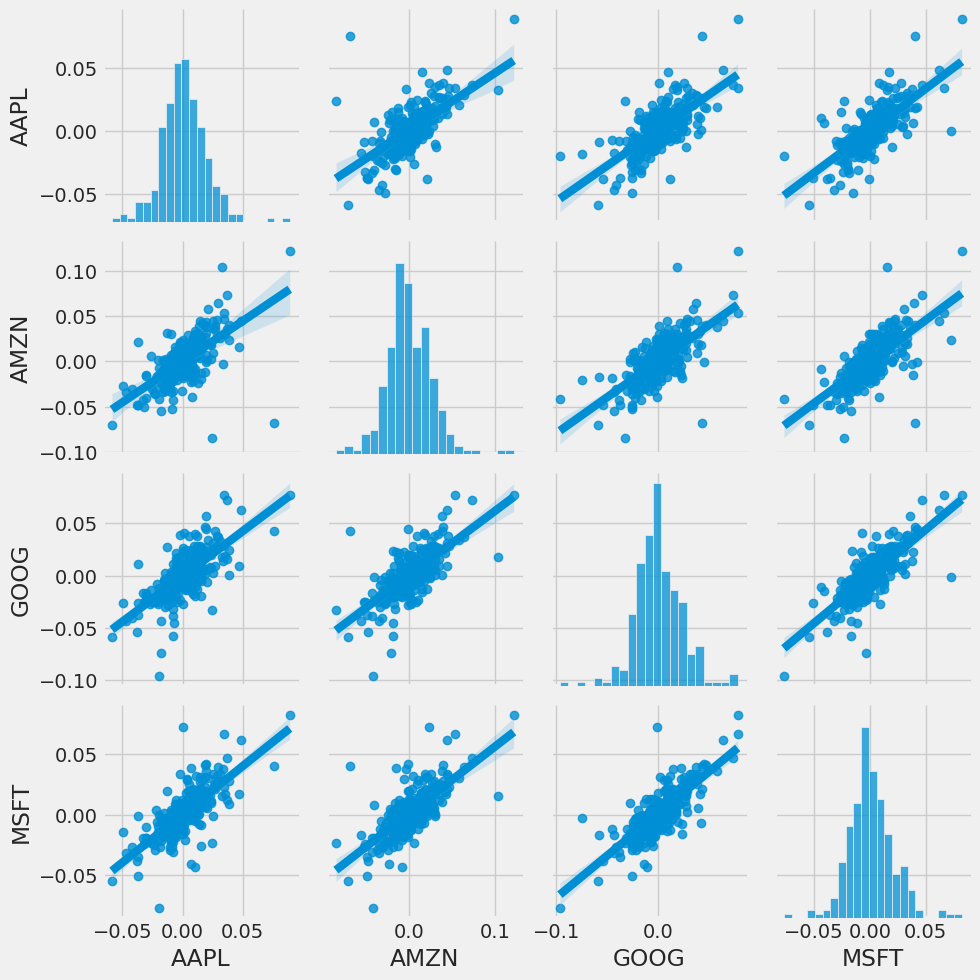

In [14]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis
# of all the comparisons

sns.pairplot(tech_rets, kind='reg')

Above we can see all the relationships on daily returns between all the stocks. A quick glance shows an interesting correlation between Google and Amazon daily returns. It might be interesting to investigate that individual comaprison.

While the simplicity of just calling sns.pairplot() is fantastic we can also use sns.PairGrid() for full control of the figure, including what kind of plots go in the diagonal, the upper triangle, and the lower triangle. Below is an example of utilizing the full power of seaborn to achieve this result.

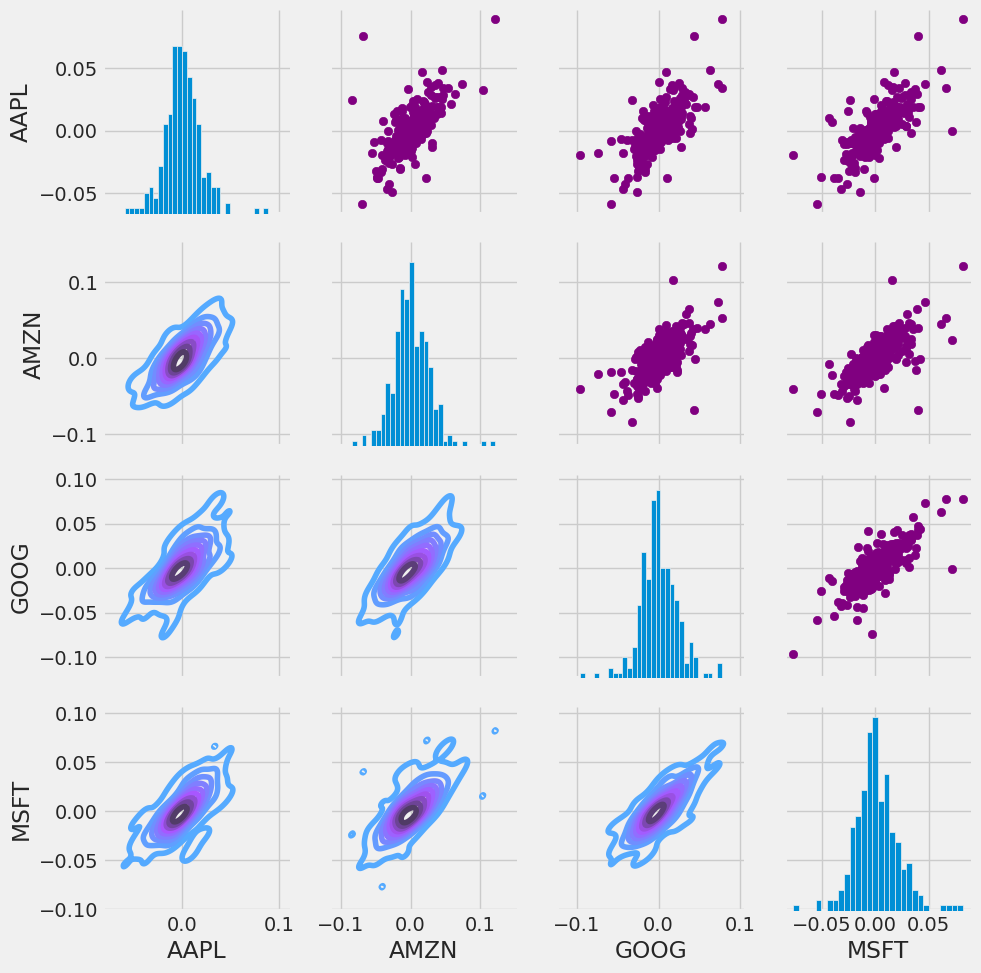

In [15]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde)
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

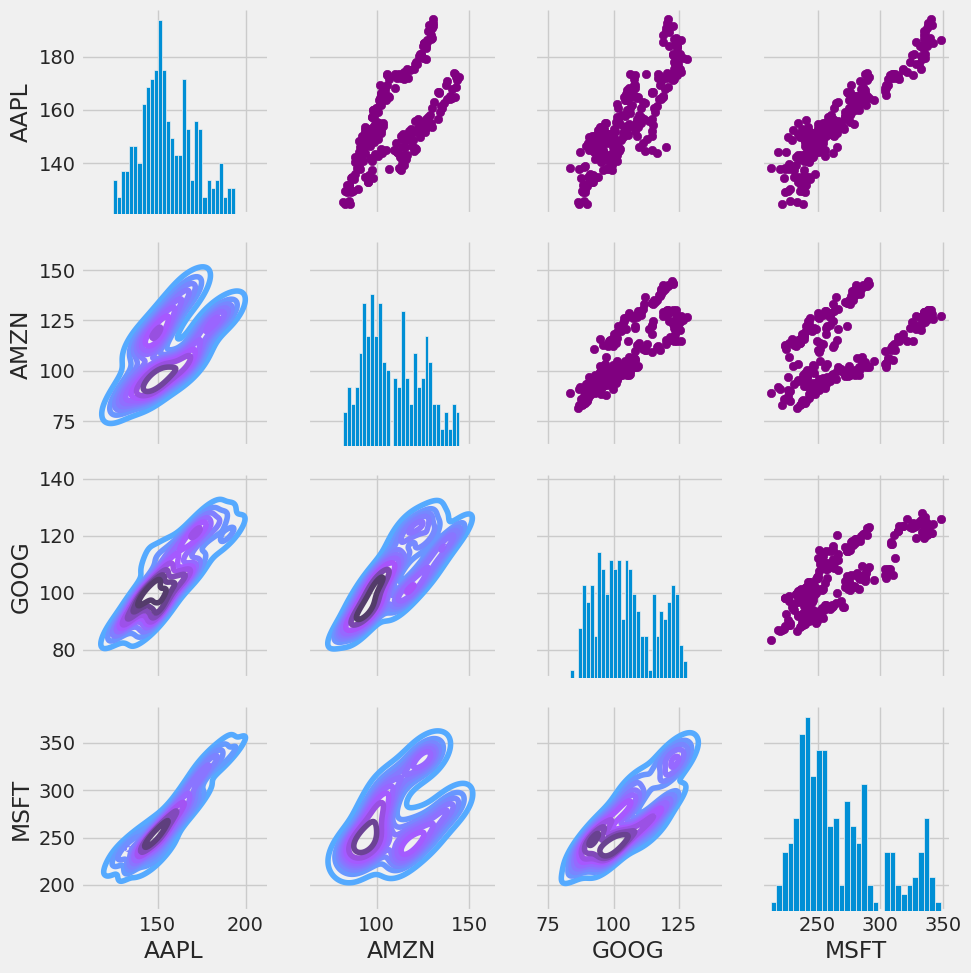

In [16]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

Finally, we could also do a correlation plot, to get actual numerical values for the correlation between the stocks' daily return values. By comparing the closing prices, we see an interesting relationship between Microsoft and Apple.

Text(0.5, 1.0, 'Correlation of stock closing price')

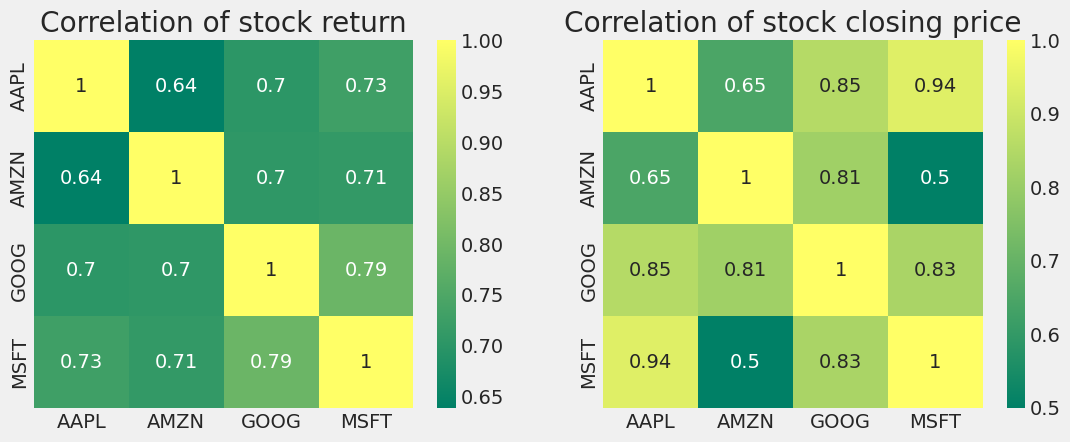

In [17]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

Just like we suspected in our PairPlot we see here numerically and visually that Microsoft and Amazon had the strongest correlation of daily stock return. It's also interesting to see that all the technology comapnies are positively correlated.

# 5. How much value do we put at risk by investing in a particular stock?


There are many ways we can quantify risk, one of the most basic ways using the information we've gathered on daily percentage returns is by comparing the expected return with the standard deviation of the daily returns.

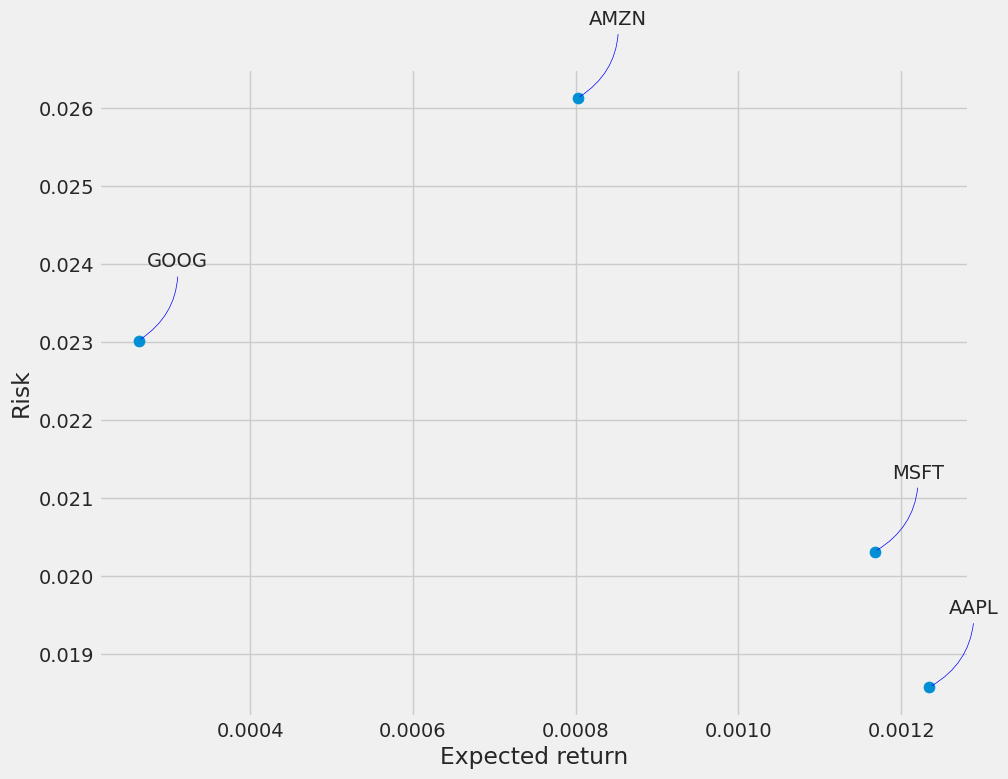

In [18]:
# Drop NaN Values
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

# 6. Predicting the closing price stock price of APPLE inc:

In [19]:
# Get the stock quote
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# Show teh data
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.482925,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.550012,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.689340,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.821990,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.801657,394024400
...,...,...,...,...,...,...
2023-06-30,191.630005,194.479996,191.259995,193.970001,193.970001,85069600
2023-07-03,193.779999,193.880005,191.759995,192.460007,192.460007,31458200
2023-07-05,191.570007,192.979996,190.619995,191.330002,191.330002,46920300


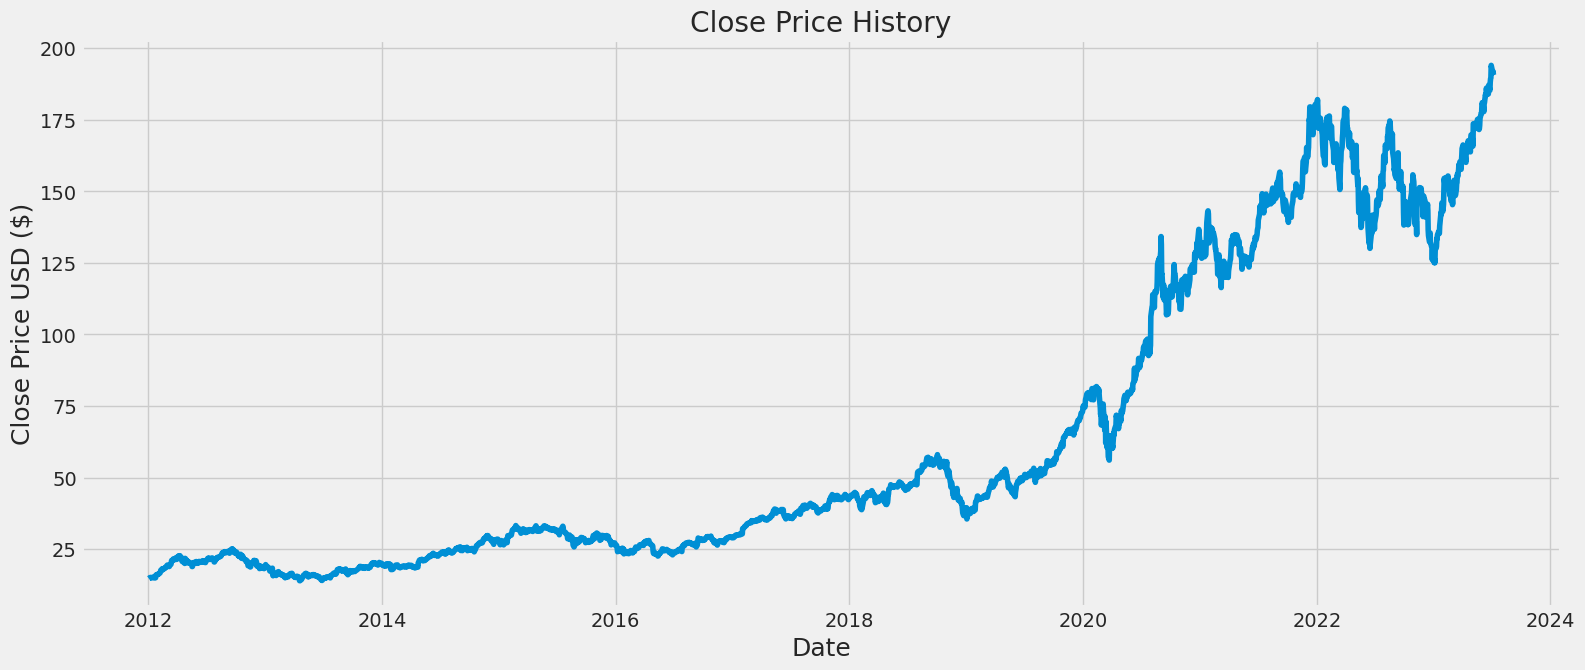

In [20]:
plt.figure(figsize=(17,7))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [21]:
# Create a new dataframe with only the 'Close column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2752

In [22]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00410663],
       [0.00454506],
       [0.00545566],
       ...,
       [0.98533517],
       [0.98800148],
       [0.98172446]])

In [23]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00410663, 0.00454506, 0.00545566, 0.00632262, 0.0061897 ,
       0.00648927, 0.00635238, 0.00612225, 0.00580879, 0.00677891,
       0.00765381, 0.007384  , 0.005906  , 0.00731654, 0.00592783,
       0.01113551, 0.01073279, 0.01125851, 0.01239527, 0.01308368,
       0.01302615, 0.01281387, 0.01371852, 0.0145696 , 0.01553377,
       0.01709112, 0.02036253, 0.02041213, 0.02223333, 0.02359427,
       0.02125528, 0.02215596, 0.02213811, 0.02466359, 0.0243045 ,
       0.0249691 , 0.02616339, 0.026828  , 0.02874244, 0.0301371 ,
       0.03053983, 0.03068069, 0.02829607, 0.02772074, 0.02780605,
       0.03004784, 0.03067871, 0.0320337 , 0.03522774, 0.03948911,
       0.03869159, 0.03869357, 0.04177454, 0.04273871, 0.04205228,
       0.04142538, 0.04077268, 0.04294106, 0.04442897, 0.04505191])]
[0.043512415186967204]

[array([0.00410663, 0.00454506, 0.00545566, 0.00632262, 0.0061897 ,
       0.00648927, 0.00635238, 0.00612225, 0.00580879, 0.00677891,
       0.00765381, 0.007384  , 0.0

In [24]:
!pip install tensorflow

In [25]:
!pip install tensorflow
!pip install keras


In [26]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [27]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2692/2692 [==============================] - 41s 11ms/step - loss: 0.0011


In [28]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 1s 5ms/step


3.9404458220848073

## VIsualization

<ipython-input-29-4b38a0f42300>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


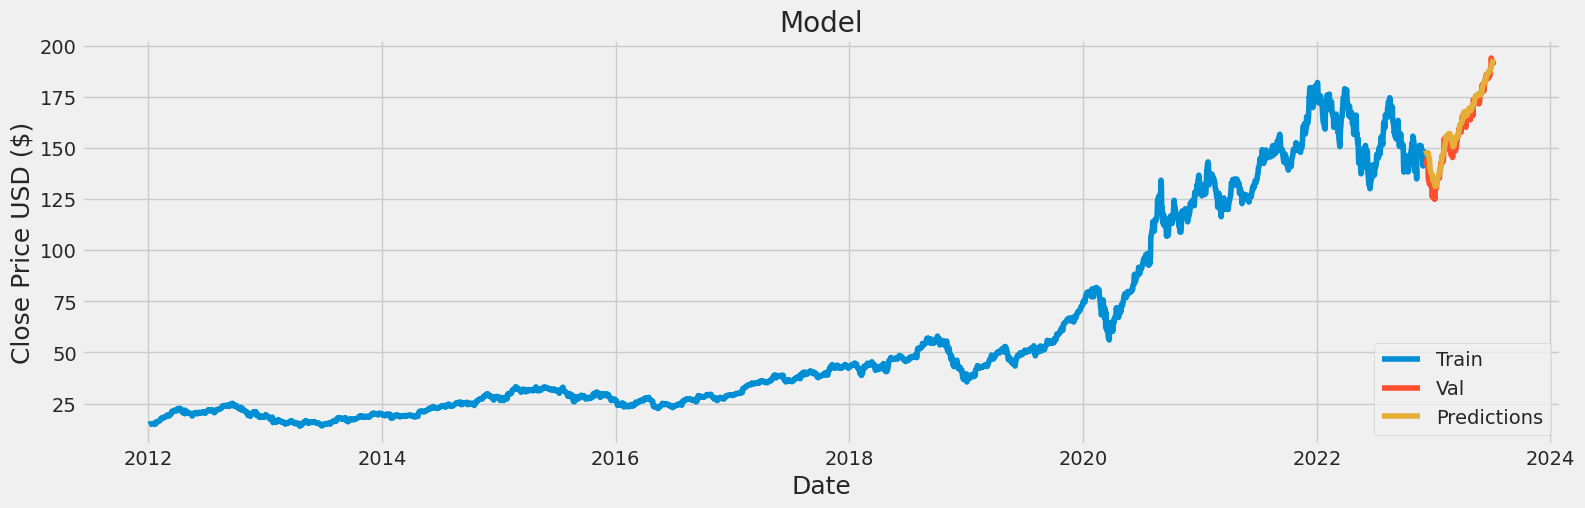

In [29]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(17,5))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [30]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2022-12-08,142.649994,148.774643
2022-12-09,142.160004,147.849792
2022-12-12,144.490005,147.106735
2022-12-13,145.470001,147.024521
2022-12-14,143.210007,147.437088
...,...,...
2023-06-30,193.970001,189.797913
2023-07-03,192.460007,191.255066
2023-07-05,191.330002,192.416626


# Summary
In this notebook, you discovered and explored stock data.

Specifically, you learned:

- How to load stock market data from the YAHOO Finance website using yfinance.
- How to explore and visualize time-series data using Pandas, Matplotlib, and Seaborn.
- How to measure the correlation between stocks.
- How to measure the risk of investing in a particular stock.